# Let's Get Familiar with PSG Data

In [1]:
%load_ext autoreload
%autoreload 2

import os
os.chdir('..')

from pathlib import Path
import matplotlib.pyplot as plt
import pprint

import numpy as np

from openpsg.utils.vis_tools.datasets import coco_dir
from openpsg.utils.vis_tools.preprocess import load_json

from detectron2.data.detection_utils import read_image
from detectron2.utils.colormap import colormap
from panopticapi.utils import rgb2id

def get_colormap(num_colors: int):
    return (np.resize(colormap(), (num_colors, 3))).tolist()

/home/interns2022/miniconda3/envs/openpsg/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading PSG Data

This script help users to get familiar with PSG data.
All PSG annotations are stored in `psg.json`.
We also provide `tiny_psg.json`, which contains 1/4 size of original training and 1000 val samples to accelerate debugging process.
We first load `psg.json`.

In [3]:
# set working path as home dir to easy access data
psg_dataset_file = load_json(Path("data/psg/psg.json"))
print('keys: ', list(psg_dataset_file.keys()))

keys:  ['data', 'thing_classes', 'stuff_classes', 'predicate_classes', 'test_image_ids']


You can see that psg_dataset_file contains the label system represented by 'thing_classes', 'stuff_classes', 'predicate_classes'.
'test_image_ids' shows the index for test (in fact validation set). Some details are as below.

In [4]:
psg_thing_cats = psg_dataset_file['thing_classes']
psg_stuff_cats = psg_dataset_file['stuff_classes']
psg_obj_cats = psg_thing_cats + psg_stuff_cats
psg_rel_cats = psg_dataset_file['predicate_classes']
psg_dataset = {d["image_id"]: d for d in psg_dataset_file['data']}
# psg_dataset_coco_id = {d["coco_image_id"]: d for d in psg_dataset_file['data']}

print('Number of images: {}'.format(len(psg_dataset)))
print('# Object Classes: {}'.format(len(psg_obj_cats)))
print('# Relation Classes: {}'.format(len(psg_rel_cats)))

Number of images: 48749
# Object Classes: 133
# Relation Classes: 56


## Visualize PSG data

In [5]:
example_img_id = '107902'
data = psg_dataset[example_img_id]
print('keys: ', list(psg_dataset[example_img_id].keys()))

keys:  ['file_name', 'height', 'width', 'image_id', 'pan_seg_file_name', 'segments_info', 'relations', 'annotations', 'coco_image_id']


In [6]:
# first check values other than ['pan_seg_file_name', 'segments_info', 'relations', 'annotations']
data_simple = {}
for k in data:
    if k not in ['segments_info', 'relations', 'annotations']:
        data_simple[k] = data[k]
pprint.pprint(data_simple)

{'coco_image_id': '417720',
 'file_name': 'train2017/000000417720.jpg',
 'height': 640,
 'image_id': '107902',
 'pan_seg_file_name': 'panoptic_train2017/000000417720.png',
 'width': 480}


In [7]:
pprint.pprint(data['segments_info'])

[{'area': 42555, 'category_id': 0, 'id': 3648962, 'iscrowd': 0, 'isthing': 1},
 {'area': 45880, 'category_id': 0, 'id': 3293004, 'iscrowd': 0, 'isthing': 1},
 {'area': 22774, 'category_id': 25, 'id': 4470325, 'iscrowd': 0, 'isthing': 1},
 {'area': 48824, 'category_id': 116, 'id': 4545879, 'iscrowd': 0, 'isthing': 0},
 {'area': 44811, 'category_id': 117, 'id': 7633023, 'iscrowd': 0, 'isthing': 0},
 {'area': 3417, 'category_id': 119, 'id': 14079701, 'iscrowd': 0, 'isthing': 0},
 {'area': 97238, 'category_id': 125, 'id': 3504233, 'iscrowd': 0, 'isthing': 0}]


In [8]:
pprint.pprint(data['annotations'])

[{'bbox': [49.0, 162.0, 207.0, 617.0], 'bbox_mode': 0, 'category_id': 0},
 {'bbox': [259.0, 158.0, 397.0, 631.0], 'bbox_mode': 0, 'category_id': 0},
 {'bbox': [157.0, 75.0, 469.0, 279.0], 'bbox_mode': 0, 'category_id': 25},
 {'bbox': [0.0, 0.0, 480.0, 131.0], 'bbox_mode': 0, 'category_id': 116},
 {'bbox': [0.0, 112.0, 480.0, 323.0], 'bbox_mode': 0, 'category_id': 117},
 {'bbox': [215.0, 0.0, 480.0, 54.0], 'bbox_mode': 0, 'category_id': 119},
 {'bbox': [0.0, 285.0, 480.0, 640.0], 'bbox_mode': 0, 'category_id': 125}]


In [9]:
pprint.pprint(data['relations'])

[[0, 1, 2], [0, 6, 14], [1, 2, 21], [1, 6, 14], [4, 3, 1], [5, 3, 0]]


In [20]:
print(len(data['annotations']))
for rel in data['relations']:
    obj_rel = [data['annotations'][i]['category_id'] for i in rel[:2]]
    print( obj_rel)

7
[0, 0]
[0, 125]
[0, 25]
[0, 125]
[117, 116]
[119, 116]


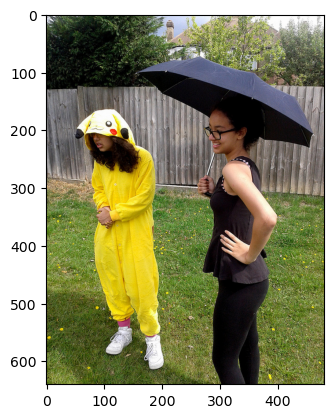

In [10]:
# show origin image
img = read_image(coco_dir / data["file_name"], format="RGB")
plt.imshow(img)
plt.show()

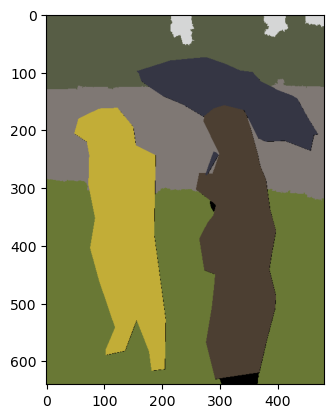

Segments IDs:  [       0  3293004  3504233  3648962  4470325  4545879  7633023 14079701]
Segments Annotations: 
[{'area': 42555, 'category_id': 0, 'id': 3648962, 'iscrowd': 0, 'isthing': 1},
 {'area': 45880, 'category_id': 0, 'id': 3293004, 'iscrowd': 0, 'isthing': 1},
 {'area': 22774, 'category_id': 25, 'id': 4470325, 'iscrowd': 0, 'isthing': 1},
 {'area': 48824, 'category_id': 116, 'id': 4545879, 'iscrowd': 0, 'isthing': 0},
 {'area': 44811, 'category_id': 117, 'id': 7633023, 'iscrowd': 0, 'isthing': 0},
 {'area': 3417, 'category_id': 119, 'id': 14079701, 'iscrowd': 0, 'isthing': 0},
 {'area': 97238, 'category_id': 125, 'id': 3504233, 'iscrowd': 0, 'isthing': 0}]


In [11]:
# show segments image
seg_map = read_image(coco_dir / data["pan_seg_file_name"], format="RGB")
plt.imshow(seg_map)
plt.show()
# show seg annotations
seg_map = rgb2id(seg_map)
print('Segments IDs: ', np.unique(seg_map))
print('Segments Annotations: ')
pprint.pprint(data["segments_info"])

In [12]:
# get seperate masks
masks = []
labels_coco = []
for i, s in enumerate(data["segments_info"]):
    label = psg_obj_cats[s["category_id"]]
    labels_coco.append(label)
    masks.append(seg_map == s["id"])

In [13]:
# generate colormap for masks
colormap_coco = get_colormap(len(data["segments_info"]))
colormap_coco = (np.array(colormap_coco) / 255).tolist()

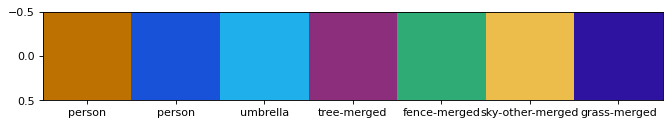

In [14]:
# show label and corresponding color
plt.figure(figsize=(10, 4), dpi=80)
plt.xticks(range(len(labels_coco)), labels_coco, fontsize=10)
plt.imshow(np.array(colormap_coco).reshape(1,-1,3))
plt.show()

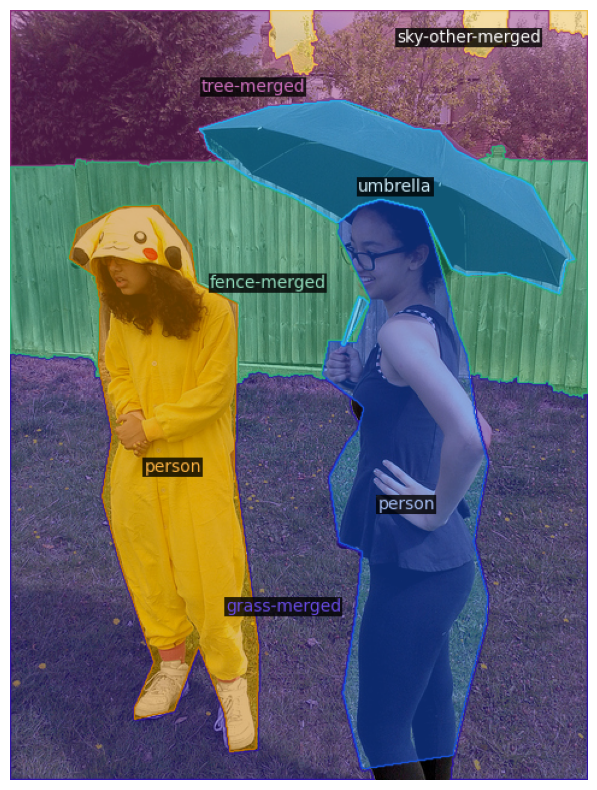

In [15]:
from openpsg.utils.vis_tools.detectron_viz import Visualizer
viz = Visualizer(img)
viz.overlay_instances(
    labels=labels_coco,
    masks=masks,
    assigned_colors=colormap_coco,
)
viz_img = viz.get_output().get_image()
plt.figure(figsize=(10,10))
plt.imshow(viz_img)
plt.axis('off')
plt.show()

In [16]:
# show triplets
for s_idx, o_idx, rel_id in data["relations"]:
    s_label = labels_coco[s_idx]
    o_label = labels_coco[o_idx]
    rel_label = psg_rel_cats[rel_id]
    print(s_label, rel_label, o_label)

person beside person
person standing on grass-merged
person holding umbrella
person standing on grass-merged
fence-merged in front of tree-merged
sky-other-merged over tree-merged
